# Import Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define Images Path

In [ ]:
image_paths = [
    './logo_1.jpg',
    './logo_2.jpg',
    './logo_3.jpg',
    './logo_4.jpg',
    ]

# Main Operations


Processing: ./logo_1.jpg


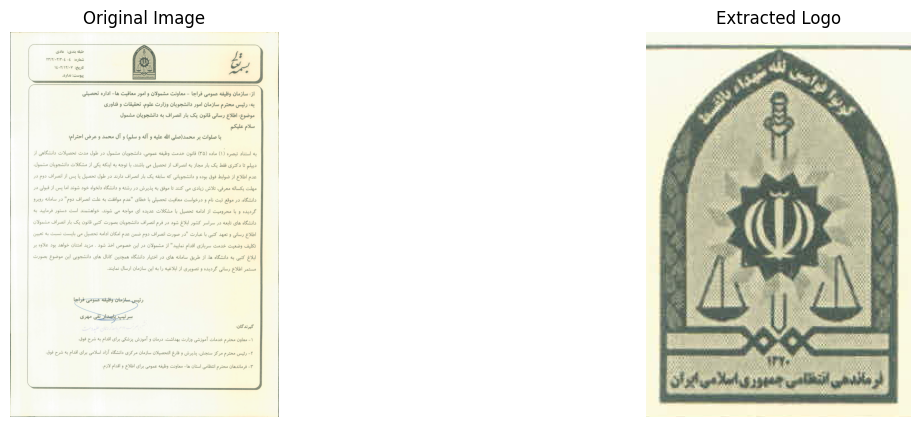


Processing: ./logo_2.jpg


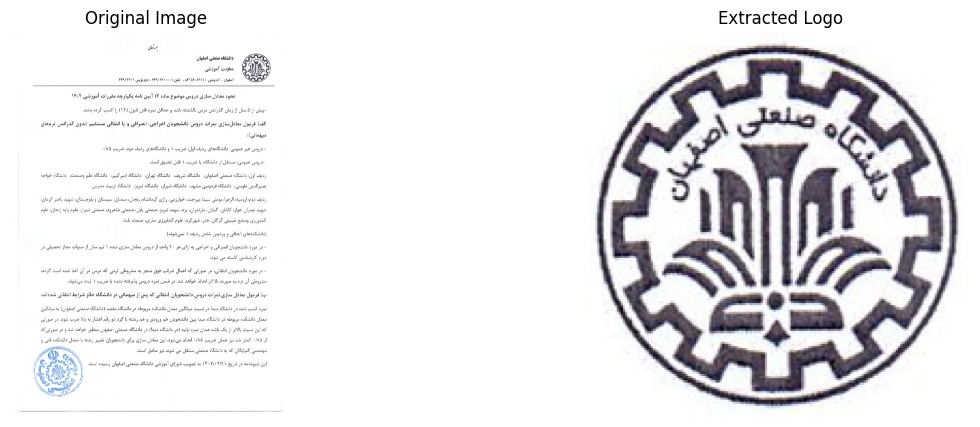


Processing: ./logo_3.jpg


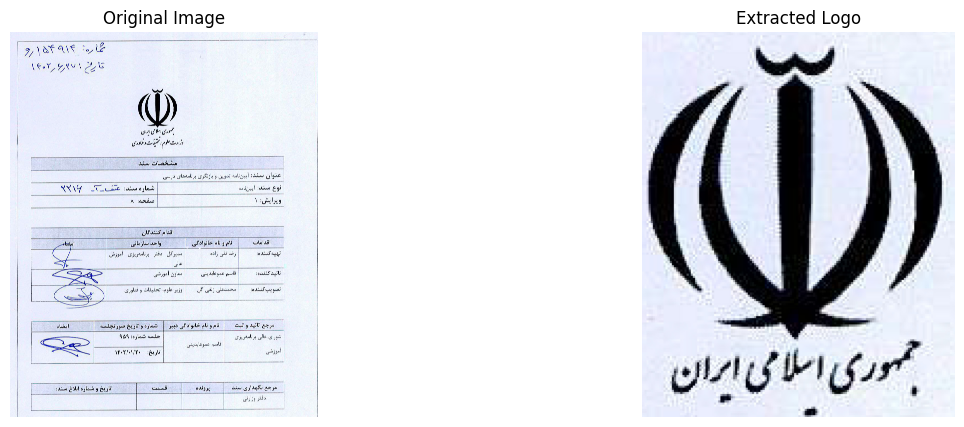


Processing: ./logo_4.jpg


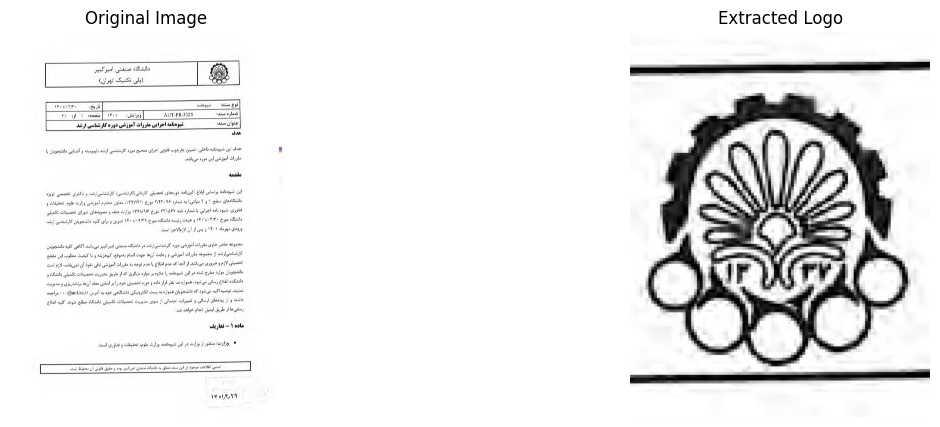

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import canny
from skimage.filters import sobel

def preprocess_image(img):
    """Preprocess the image for better logo detection."""
    # Convert to RGB and grayscale
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )

    # Enhance edges
    edges = canny(gray, sigma=2)
    edges = edges.astype(np.uint8) * 255

    return img_rgb, gray, thresh, edges

def apply_morphological_operations(binary_img):
    """Apply various morphological operations to clean the image."""
    # Create different structural elements
    kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    kernel_ellip = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # Apply multiple morphological operations
    cleaned = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel_rect)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel_ellip)
    cleaned = cv2.dilate(cleaned, kernel_rect, iterations=1)

    return cleaned

def preprocess_image1(img):
    """Preprocess the image for better logo detection."""
    # Convert to RGB and grayscale
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding
    block_size = max(11, (min(img.shape[:2]) // 20) * 2 + 1)  # Adaptive block size
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, block_size, 5
    )

    # Combine edge detection methods
    edges_canny = canny(gray, sigma=2).astype(np.uint8) * 255
    edges_sobel = sobel(gray)
    edges_sobel = (edges_sobel * 255 / np.max(edges_sobel)).astype(np.uint8)
    edges = cv2.bitwise_or(edges_canny, edges_sobel)

    return img_rgb, gray, thresh, edges

def apply_morphological_operations1(binary_img, img_size):
    """Apply various morphological operations to clean the image."""
    # Calculate kernel size based on image size
    kernel_size = max(3, img_size // 100)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

    # Apply morphological operations
    cleaned = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
    cleaned = cv2.dilate(cleaned, kernel, iterations=1)

    return cleaned

def detect_potential_logos(cleaned_img, original_img):
    """Detect potential logo regions using multiple techniques."""
    # Find contours
    contours, _ = cv2.findContours(
        cleaned_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    potential_logos = []
    height, width = original_img.shape[:2]
    min_area = (width * height) * 0.001  # Minimum 0.1% of image area
    max_area = (width * height) * 0.2    # Maximum 20% of image area

    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            # Get bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)

            # Calculate aspect ratio and solidity
            aspect_ratio = float(w)/h
            hull = cv2.convexHull(contour)
            hull_area = cv2.contourArea(hull)
            solidity = float(area)/hull_area if hull_area > 0 else 0

            # Filter based on shape characteristics
            if 0.1 < aspect_ratio < 2.0 and solidity > 0.1:
                # Add padding around the region
                padding = 10
                x1 = max(0, x - padding)
                y1 = max(0, y - padding)
                x2 = min(width, x + w + padding)
                y2 = min(height, y + h + padding)

                potential_logos.append((x1, y1, x2, y2))

    return potential_logos

def analyze_region_features(img_rgb, x1, y1, x2, y2):
    """Analyze features of a potential logo region."""
    region = img_rgb[y1:y2, x1:x2]

    # Convert to grayscale and calculate features
    gray_region = cv2.cvtColor(region, cv2.COLOR_RGB2GRAY)

    # Calculate edge density
    edges = sobel(gray_region)
    edge_density = np.mean(edges)

    # Calculate color variance
    color_variance = np.var(region)

    # Calculate intensity contrast
    intensity_contrast = np.max(gray_region) - np.min(gray_region)

    return edge_density, color_variance, intensity_contrast

def select_best_logo(img_rgb, potential_logos):
    """Select the best logo candidate based on various features."""
    if not potential_logos:
        return None

    best_score = -1
    best_logo = None

    for x1, y1, x2, y2 in potential_logos:
        edge_density, color_variance, intensity_contrast = analyze_region_features(
            img_rgb, x1, y1, x2, y2
        )

        # Calculate combined score
        score = (edge_density * 0.4 +
                (color_variance / 10000) * 0.3 +
                (intensity_contrast / 255) * 0.3)

        if score > best_score:
            best_score = score
            best_logo = (x1, y1, x2, y2)

    if best_logo:
        x1, y1, x2, y2 = best_logo
        return img_rgb[y1:y2, x1:x2]
    return None

def extract_logo(image_path, iteration_count):
    """Main function to extract logo from an image.

    Args:
        image_path: Path to the image file
        iteration_count: Current iteration number to control processing flow
    """
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error reading image: {image_path}")
        return

    if iteration_count < 3:  # First three iterations
        # Preprocess image
        img_rgb, gray, thresh, edges = preprocess_image(img)

        # Clean up binary image
        cleaned = apply_morphological_operations(thresh)
    else:  # Fourth iteration
        # Preprocess image
        img_rgb, gray, thresh, edges = preprocess_image1(img)

        # Get image dimensions
        height, width = thresh.shape
        img_size = max(height, width)  # Use the larger dimension for kernel size calculation

        # Clean up binary image
        cleaned = apply_morphological_operations1(thresh, img_size)

    # Detect potential logo regions
    potential_logos = detect_potential_logos(cleaned, img)

    # Select best logo
    selected_logo = select_best_logo(img_rgb, potential_logos)

    # Visualize results
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.axis('off')

    if selected_logo is not None:
        plt.subplot(122)
        plt.imshow(selected_logo)
        plt.title('Extracted Logo')
        plt.axis('off')
    else:
        print("No suitable logo found.")

    plt.show()

    return selected_logo

# Process multiple images
iteration_count = 0
for image_path in image_paths:
    print(f"\nProcessing: {image_path}")
    extract_logo(image_path, iteration_count)
    iteration_count = (iteration_count + 1)
